In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph
import math

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Wisconsin
state_ab = "wi"

## Data
1. Download all the data in directory "wi_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2022/POLYGON.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2023/SenateDistricts_2023WIAct94/SenateDistricts_2023WIAct94.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2023/AssemblyDistricts_2023WIAct94/AssemblyDistricts_2023WIAct94.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [6]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    # Edited this to now throw exception.  Upon inspection, the hole is Lake Winnebago
    if maup.doctor(df) == False:
        print("There was some issue.  Check it out!")
        #raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        if not math.isnan(election_df.at[precinct_index, dist_name]): #Note: added this b/c of hole over Lake Winnebago
            election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [12]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [13]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [15]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [16]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [17]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [18]:
maup.doctor(population_df)

100%|█████████████████████████████████| 203059/203059 [01:15<00:00, 2704.33it/s]


True

In [19]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [20]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [21]:
population_df.rename(columns=rename_dict, inplace = True)

In [22]:
county_df = county_df.to_crs(county_df.estimate_utm_crs())
maup.doctor(county_df)

100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 657.34it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [25]:
vest20 = gpd.read_file(vest20_data)

In [26]:
vest20.columns

Index(['CNTY_FIPS', 'CNTY_NAME', 'MCD_FIPS', 'MCD_NAME', 'CTV', 'WARDID',
       'LABEL', 'PERSONS', 'RV', 'G20PREDBID', 'G20PRERTRU', 'G20PRECBLA',
       'G20PRELJOR', 'G20PREICAR', 'G20PREOWEL', 'G20PREOSIM', 'G20PREOBOD',
       'G20PREOHAW', 'G20PREOLAR', 'G20PREOWES', 'G20PREOCHA', 'G20PREOWRI',
       'geometry'],
      dtype='object')

In [27]:
start_col = 9
vest_base_data = vest20
year = '20'

In [28]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 674.55it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 176.15it/s]


Identifying overlaps...


100%|███████████████████████████████████| 15336/15336 [00:04<00:00, 3198.58it/s]


Resolving overlaps and filling gaps...


Gaps to fill in region 1: 100%|█████████████████| 66/66 [00:00<00:00, 81.58it/s]
Gaps to simplify in region 2: 40it [00:07,  5.69it/s]                           
Gaps to fill in region 7: 100%|█████████████████| 17/17 [00:00<00:00, 48.14it/s]


2 gaps in region 8 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 9: 100%|█████████████████| 18/18 [00:00<00:00, 49.67it/s]


1 gaps in region 10 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 11: 100%|████████████████| 67/67 [00:00<00:00, 90.23it/s]
Gaps to simplify in region 12: 73it [00:01, 45.45it/s]                          
Gaps to fill in region 12: 100%|████████████████| 34/34 [00:01<00:00, 31.10it/s]
Gaps to simplify in region 13: 155it [00:04, 38.29it/s]                         
Gaps to fill in region 13: 100%|████████████████| 32/32 [00:01<00:00, 19.40it/s]


1 gaps in region 14 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 17: 100%|████████████████| 25/25 [00:00<00:00, 58.78it/s]


1 gaps in region 18 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 19: 100%|██████████████████| 7/7 [00:00<00:00,  7.37it/s]


1 gaps in region 20 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 22: 100%|████████████████| 18/18 [00:00<00:00, 33.93it/s]


1 gaps in region 23 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 24: 100%|██████████████████| 7/7 [00:00<00:00, 44.93it/s]


1 gaps in region 25 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 26: 100%|██████████████████| 9/9 [00:01<00:00,  6.99it/s]


1 gaps in region 27 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 28: 100%|████████████████| 12/12 [00:00<00:00, 96.31it/s]
Gaps to simplify in region 29: 119it [00:02, 51.72it/s]                         
Gaps to fill in region 31: 100%|████████████████| 64/64 [00:00<00:00, 71.54it/s]
Gaps to simplify in region 32: 78it [00:01, 52.65it/s]                          
Gaps to fill in region 37: 100%|██████████████████| 5/5 [00:00<00:00, 46.83it/s]


1 gaps in region 38 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 38: 100%|████████████████| 15/15 [00:00<00:00, 27.19it/s]


1 gaps in region 39 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 39: 100%|██████████████████| 6/6 [00:00<00:00, 50.76it/s]
Gaps to simplify in region 40: 93it [00:15,  5.87it/s]                          
Gaps to fill in region 45: 100%|████████████████| 14/14 [00:00<00:00, 40.99it/s]
Gaps to simplify in region 46: 36it [00:04,  8.55it/s]                          
Gaps to fill in region 46: 100%|████████████████| 28/28 [00:01<00:00, 22.68it/s]
Gaps to simplify in region 47: 41it [00:09,  4.18it/s]                          
Gaps to fill in region 47: 100%|████████████████| 74/74 [00:00<00:00, 79.05it/s]


1 gaps in region 48 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 48: 100%|████████████████| 12/12 [00:00<00:00, 21.36it/s]


1 gaps in region 49 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 49: 100%|████████████████| 29/29 [00:01<00:00, 19.55it/s]


1 gaps in region 50 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 56: 100%|████████████████| 20/20 [00:00<00:00, 28.84it/s]


1 gaps in region 57 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 57: 100%|██████████████████| 6/6 [00:00<00:00, 10.80it/s]


1 gaps in region 58 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 58: 100%|████████████████| 13/13 [00:00<00:00, 35.90it/s]
Gaps to simplify in region 59: 64it [00:01, 40.65it/s]                          
Gaps to fill in region 59: 100%|████████████████| 31/31 [00:00<00:00, 36.72it/s]


1 gaps in region 60 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 61: 100%|██████████████████| 7/7 [00:00<00:00, 43.75it/s]


1 gaps in region 62 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 62: 100%|████████████████| 24/24 [00:00<00:00, 44.06it/s]


2 gaps in region 63 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 63: 100%|███████████| 11/11 [00:00<00:00, 142.51it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 64: 100%|████████████████| 11/11 [00:00<00:00, 66.33it/s]
Gaps to simplify in region 65: 66it [00:08,  7.83it/s]                          
Gaps to fill in region 66: 100%|████████████████| 51/51 [00:00<00:00, 95.57it/s]
Gaps to simplify in region 67: 60it [00:00, 110.15it/s]                         
Gaps to fill in region 67: 100%|████████████████| 14/14 [00:00<00:00, 42.87it/s]


1 gaps in region 68 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 70: 100%|███████████████| 40/40 [00:00<00:00, 107.82it/s]
Gaps to simplify in region 71: 154it [00:02, 58.29it/s]                         
Gaps to fill in region 71: 100%|████████████████| 25/25 [00:00<00:00, 63.11it/s]


In [29]:
borders = check_small_boundary_lengths(vest_base)
print(borders[3500:5300])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [30]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5, snap_precision = 8)

Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 8539/8539 [00:02<00:00, 4091.78it/s]


Resolving overlaps...
1 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to fill: 100%|███████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


Converting small rook adjacencies to queen...


100%|█████████████████████████████████████| 7093/7093 [00:04<00:00, 1617.60it/s]


There are 1 holes.
There was some issue.  Check it out!


In [31]:
maup.doctor(vest_base)

100%|█████████████████████████████████████| 7093/7093 [00:04<00:00, 1509.97it/s]


There are 1 holes.


False

Let's take a look at the hole:

<Axes: >

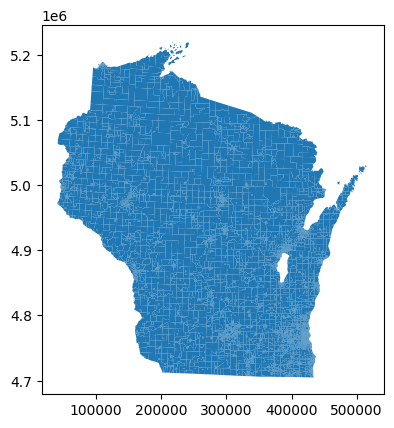

In [33]:
vest_base.plot()

It's Lake Winnebago.  No problems here, so let's keep going.

In [35]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 7093/7093 [00:15<00:00, 450.21it/s]


In [36]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [37]:
election_df = gpd.GeoDataFrame(vest_base)

In [38]:
election_df.columns

Index(['CNTY_FIPS', 'CNTY_NAME', 'CTV', 'LABEL', 'MCD_FIPS', 'MCD_NAME',
       'PERSONS', 'PRE20D', 'PRE20O', 'PRE20R', 'RV', 'WARDID', 'geometry',
       'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN',
       'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP',
       'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [40]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [42]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [43]:
vest18.columns

Index(['CNTY_FIPS', 'CNTY_NAME', 'MCD_FIPS', 'MCD_NAME', 'CTV', 'WARDID',
       'LABEL', 'PERSONS', 'RV', 'G18USSRVUK', 'G18USSDBAL', 'G18USSOWAL',
       'G18USSOSCH', 'G18USSOWRI', 'G18GOVRWAL', 'G18GOVDEVE', 'G18GOVLAND',
       'G18GOVGWHI', 'G18GOVITUR', 'G18GOVIENZ', 'G18GOVOCAS', 'G18GOVOBOU',
       'G18GOVOGRI', 'G18GOVOLAN', 'G18GOVOHOF', 'G18GOVOTUR', 'G18GOVONO1',
       'G18GOVONO2', 'G18GOVOWRI', 'G18ATGRSCH', 'G18ATGDKAU', 'G18ATGCLAR',
       'G18ATGOWRI', 'G18SOSRSCH', 'G18SOSDLAF', 'G18SOSOKAR', 'G18SOSOWRI',
       'G18TRERHAR', 'G18TREDGOD', 'G18TRECZUE', 'G18TREOWRI', 'geometry'],
      dtype='object')

In [44]:
vest16.columns

Index(['CNTY_FIPS', 'CNTY_NAME', 'MCD_FIPS', 'MCD_NAME', 'CTV', 'WARDID',
       'LABEL', 'PERSONS', 'RV', 'G16PRERTRU', 'G16PREDCLI', 'G16PRECCAS',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREWMOO', 'G16PREADEL', 'G16PREOFOX',
       'G16PREOMCM', 'G16PREOMAT', 'G16PREOSCH', 'G16PREOKEN', 'G16PREOKOT',
       'G16PREOHOE', 'G16PREOMAL', 'G16PREOSOL', 'G16PREOWRI', 'G16USSRJOH',
       'G16USSDFEI', 'G16USSLAND', 'G16USSOSCH', 'G16USSOWRI', 'geometry'],
      dtype='object')

In [45]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|█████████████████████████████████████| 6997/6997 [00:04<00:00, 1620.19it/s]


There are 2460 overlaps.
There are 2999 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████| 14891/14891 [00:03<00:00, 3957.57it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
2 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 2912it [49:22,  1.02s/it]                                     
100%|█████████████████████████████████████| 6997/6997 [00:04<00:00, 1490.57it/s]


There are 2 holes.
There was some issue.  Check it out!


100%|██████████████████████████████████████| 7093/7093 [00:15<00:00, 465.05it/s]


population agrees


In [46]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R', 'BVAP',
       'CNTY_FIPS', 'CNTY_NAME', 'CTV', 'GOV18D', 'GOV18O', 'GOV18R', 'HISP',
       'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER',
       'H_WHITE', 'LABEL', 'MCD_FIPS', 'MCD_NAME', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PERSONS', 'PRE20D', 'PRE20O', 'PRE20R', 'RV', 'SOS18D',
       'SOS18O', 'SOS18R', 'TOTPOP', 'TRE18D', 'TRE18O', 'TRE18R', 'USS18D',
       'USS18O', 'USS18R', 'VAP', 'WARDID', 'WVAP', 'geometry'],
      dtype='object')

In [47]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|█████████████████████████████████████| 6881/6881 [00:04<00:00, 1629.60it/s]


There are 2684 overlaps.
There are 41201 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|████████████████████████████████████| 89163/89163 [01:53<00:00, 789.02it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
2 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 39880it [10:16:34,  1.08it/s]                                 
100%|█████████████████████████████████████| 6881/6881 [00:04<00:00, 1503.69it/s]


There are 2 holes.
There was some issue.  Check it out!


100%|██████████████████████████████████████| 7093/7093 [00:14<00:00, 473.83it/s]


population agrees


##  Add the district data

In [49]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(cong_df.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [50]:
cong_df.head()

,id,NAME,TotalPop,PopDevPc,DemPct,RepPct,WhitePct,Minority,BlackPct,Hispanic,PacificP,AsianPct,NativePc,TotalVAP,Margin,color,opacity,geometry
0,1.0,1,736715.0,0.000000,0.481142,0.491911,0.782418,0.217582,0.070932,0.102396,0.001110,0.024325,0.019329,575451.0,-0.018858,#0000FF,0.5,"POLYGON ((348358.235 4745226.043, 347592.443 4..."
1,2.0,2,736715.0,0.000000,0.694890,0.281285,0.820014,0.179986,0.046568,0.056653,0.001187,0.057611,0.015589,584519.0,0.194890,#008000,0.5,"POLYGON ((286255.899 4708986.006, 286384.418 4..."
2,3.0,3,736716.0,0.000001,0.486566,0.483154,0.909480,0.090520,0.016465,0.026567,0.001084,0.024026,0.017500,580338.0,-0.013434,#8B008B,0.5,"POLYGON ((166031.420 4975754.206, 166071.488 4..."
3,4.0,4,736714.0,-0.000001,0.734541,0.241345,0.470504,0.529496,0.314626,0.153485,0.001446,0.051948,0.021316,558133.0,0.234541,#FF0000,0.5,"POLYGON ((427547.312 4764043.628, 427625.398 4..."
4,5.0,5,736715.0,0.000000,0.346921,0.630317,0.883632,0.116368,0.019442,0.047246,0.000904,0.030984,0.013157,578845.0,-0.153079,#FFD700,0.5,"POLYGON ((383425.419 4738101.544, 383420.384 4..."


In [51]:
maup.doctor(election_df)

100%|█████████████████████████████████████| 7093/7093 [00:04<00:00, 1642.96it/s]


There are 1 holes.


False

<Axes: >

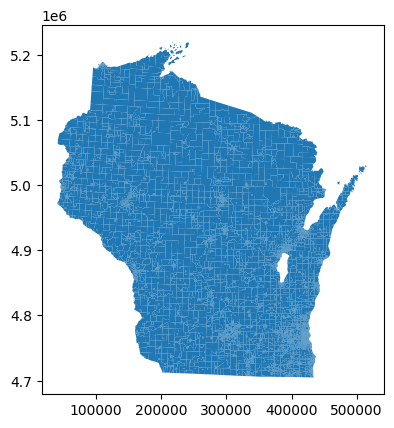

In [52]:
election_df.plot()

We can see the congressional map doesn't have the hole over Lake Winnebago, so we edit the add_district to account for this.

<Axes: >

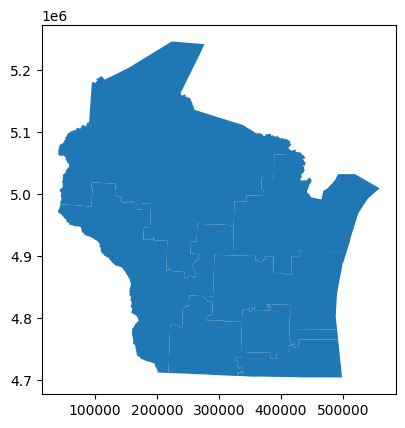

In [54]:
cong_df.plot()

In [55]:
election_df = add_district(cong_df, "CD", election_df, "NAME")

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 29.90it/s]


In [56]:
send.head()

,OBJECTID,Shape_Leng,Shape_Area,SENATE,geometry
0,1,2.566443e+06,5.155888e+10,1,"MULTIPOLYGON (((498925.213 5016044.828, 498933..."
1,2,1.473901e+06,5.524345e+10,2,"MULTIPOLYGON (((348172.482 4997850.166, 351482..."
2,3,1.400972e+05,6.946387e+08,3,"POLYGON ((421158.383 4765580.221, 421159.691 4..."
3,4,2.646938e+05,1.268358e+09,4,"POLYGON ((418436.498 4782690.011, 419210.484 4..."
4,5,3.463743e+05,2.417924e+09,5,"POLYGON ((396616.279 4773271.884, 396617.907 4..."


In [57]:
election_df = add_district(send, "SEND", election_df, "SENATE")

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 240.92it/s]


There are 1 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████████████████████████████████████| 81/81 [00:00<00:00, 690.06it/s]

Resolving overlaps...


1 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 238.97it/s]


There are 1 holes.
There was some issue.  Check it out!


100%|███████████████████████████████████████████| 33/33 [00:01<00:00, 28.60it/s]


In [58]:
hdist.head()

,OBJECTID,Shape_Leng,Shape_Area,ASSEMBLY,SENATE,geometry
0,1,1.873849e+06,2.581278e+10,1,1,"MULTIPOLYGON (((498925.213 5016044.828, 498933..."
1,2,7.253799e+05,1.282797e+10,2,1,"POLYGON ((419092.784 4921808.321, 420036.215 4..."
2,3,6.075071e+05,1.291813e+10,3,1,"POLYGON ((387892.175 4899943.801, 387958.589 4..."
3,4,8.283451e+05,1.222152e+10,4,2,"MULTIPOLYGON (((393617.849 4986900.183, 393782..."
4,5,5.392780e+05,7.466785e+09,5,2,"POLYGON ((382136.945 4938423.769, 382156.045 4..."


In [59]:
election_df = add_district(hdist, "HDIST", election_df, "ASSEMBLY")

100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 451.47it/s]


There are 1 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 147/147 [00:00<00:00, 1350.61it/s]

Resolving overlaps...


1 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 450.42it/s]


There are 1 holes.
There was some issue.  Check it out!


100%|███████████████████████████████████████████| 99/99 [00:01<00:00, 69.96it/s]


In [60]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R', 'BVAP',
       'CNTY_FIPS', 'CNTY_NAME', 'CTV', 'GOV18D', 'GOV18O', 'GOV18R', 'HISP',
       'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER',
       'H_WHITE', 'LABEL', 'MCD_FIPS', 'MCD_NAME', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PERSONS', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O',
       'PRE20R', 'RV', 'SOS18D', 'SOS18O', 'SOS18R', 'TOTPOP', 'TRE18D',
       'TRE18O', 'TRE18R', 'USS16D', 'USS16O', 'USS16R', 'USS18D', 'USS18O',
       'USS18R', 'VAP', 'WARDID', 'WVAP', 'geometry', 'CD', 'SEND', 'HDIST'],
      dtype='object')

In [61]:
maup.doctor(election_df)

100%|█████████████████████████████████████| 7093/7093 [00:04<00:00, 1655.29it/s]


There are 1 holes.


False

### We need to remove the precinct that didn't get assigned to the districts:

In [63]:
election_df[election_df['SEND'].isna()]

,2MOREVAP,AMINVAP,ASIANVAP,ATG18D,ATG18O,ATG18R,BVAP,CNTY_FIPS,CNTY_NAME,CTV,...,USS18D,USS18O,USS18R,VAP,WARDID,WVAP,geometry,CD,SEND,HDIST
6678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55025,DANE,C,...,0.0,0.0,0.0,0.0,0020,0.0,POLYGON EMPTY,NaN,NaN,NaN


In [64]:
election_df[election_df['CD'].isna()]

,2MOREVAP,AMINVAP,ASIANVAP,ATG18D,ATG18O,ATG18R,BVAP,CNTY_FIPS,CNTY_NAME,CTV,...,USS18D,USS18O,USS18R,VAP,WARDID,WVAP,geometry,CD,SEND,HDIST
6678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55025,DANE,C,...,0.0,0.0,0.0,0.0,0020,0.0,POLYGON EMPTY,NaN,NaN,NaN


In [65]:
election_df[election_df['HDIST'].isna()]

,2MOREVAP,AMINVAP,ASIANVAP,ATG18D,ATG18O,ATG18R,BVAP,CNTY_FIPS,CNTY_NAME,CTV,...,USS18D,USS18O,USS18R,VAP,WARDID,WVAP,geometry,CD,SEND,HDIST
6678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55025,DANE,C,...,0.0,0.0,0.0,0.0,0020,0.0,POLYGON EMPTY,NaN,NaN,NaN


It's OK to remove b/c it has no population:

In [67]:
election_df[election_df['HDIST'].isna()]['TOTPOP']

6678    0.0
Name: TOTPOP, dtype: float64

In [68]:
election_df = election_df.dropna(subset=['SEND'])

### Put the base precinct year after the precinct information column

In [70]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'CNTY_FIPS':'CNTY_FIPS'+year, 
        'CNTY_NAME':'CNTY_NAME'+year, 
        'MCD_FIPS':'MCD_FIPS'+year,
        'MCD_NAME':'MCD_NAME'+year,
        'CTV':'CTV'+year,
        'WARDID':'WARDID'+year,
        'LABEL':'LABEL'+year,
        'PERSONS':'PERSONS'+year,
        'RV':'RV'+year,}
election_df.rename(columns=base_columns, inplace = True)

In [71]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R', 'BVAP',
       'CNTY_FIPS20', 'CNTY_NAME20', 'CTV20', 'GOV18D', 'GOV18O', 'GOV18R',
       'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI',
       'H_OTHER', 'H_WHITE', 'LABEL20', 'MCD_FIPS20', 'MCD_NAME20', 'NHPIVAP',
       'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER',
       'NH_WHITE', 'OTHERVAP', 'PERSONS20', 'PRE16D', 'PRE16O', 'PRE16R',
       'PRE20D', 'PRE20O', 'PRE20R', 'RV20', 'SOS18D', 'SOS18O', 'SOS18R',
       'TOTPOP', 'TRE18D', 'TRE18O', 'TRE18R', 'USS16D', 'USS16O', 'USS16R',
       'USS18D', 'USS18O', 'USS18R', 'VAP', 'WARDID20', 'WVAP', 'geometry',
       'CD', 'SEND', 'HDIST'],
      dtype='object')

In [72]:
# reorder the columns
fixed_columns = [
    'CNTY_FIPS'+year, 
    'CNTY_NAME'+year, 
    'MCD_FIPS'+year,
    'MCD_NAME'+year,
    'CTV'+year,
    'WARDID'+year,
    'LABEL'+year,
    'PERSONS'+year,
    'RV'+year, 
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [73]:
import os

# store the result in directory "wi"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

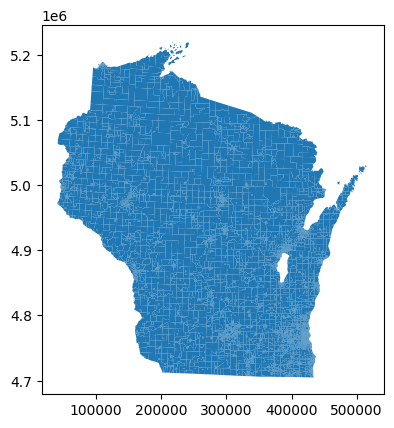

In [74]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()

In [75]:
election_df[election_df['SEND'].isna()]

,CNTY_FIPS20,CNTY_NAME20,MCD_FIPS20,MCD_NAME20,CTV20,WARDID20,LABEL20,PERSONS20,RV20,CD,...,TRE18D,TRE18O,TRE18R,USS16D,USS16O,USS16R,USS18D,USS18O,USS18R,geometry
